# Getting started exercise for RSA3.0

## Introduction

In these three exercises you will get an introduction to the functionality of the new RSA toolbox for inferring the underlying model representation based on measured data. Generally we assume that there is a true underlying representation, which is captured by our model. The measurement process like fMRI will lead to a distorted view of that representation, which we may or may not include into our analysis as an explicit measurement model.  

For illustration these exercises use simulated RDMs from the paper "Inferring brain-computational mechanisms with models of activity measurements" by Kriegeskorte & Diedrichsen (2016). Ground truth RDMs are here simulated based on the layers of Alexnet--the deep neural network model, which sparked the interest in deep learning. Simulated data rdms were generated as follows: First, voxel responses were generated by randomly selecting locations within the layer and modelling their response as a local average of the feature values. Then, noise was added to those voxel responses and RDMs were computed from these noisy responses. As model predictions to compare to, we use noise-free RDMs generated for each layer, by applying different amounts of smoothing and averaging to the layer representation. 

Our overall aim in this setting is to infer which representation the data rdms were based on, i.e. which layer was used for generating the data. Towards this aim we will make three steps:

In *Exercise 1*, we will load the data, convert them into the formats used in the toolbox and have a first exploratory look at the data.

In *Exercise 2*, we will compare the RDMs based on the undistorted representations to the simulated data RDMs. This is the classical and simplest approach and already allows us to perform model comparisons and the general evaluation of model-RDMs. This approach uses *fixed models*, i.e. each model predicts a single fixed RDM. We will see that this does not allow us to correctly infer the underlying representation though, because the measurement process distorts the RDMs too much.

((DJM note: actually it *is* possible to infer the correct underlying representation based on fixed models, at least in this example, depending on the options chosen.))

In *Exercise 3*, we will apply *flexible models*. This means that each model predicts a distribution of RDMs. In the present context this means that the model is flexible in which measurement model is applied to explain the data. To evaluate such flexible models additional cross-validation is necessary, which we also discuss in this exercise.

## Exercise 1: Data and RDM handling

In [1]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import rsatoolbox
import time     

%matplotlib inline

### Load model RDMs
Here the models are different layers of Alexnet.
For each layer, different models of how the fMRI voxels sample the neurons are being considered.

The simulated data were generated in Matlab (Kriegeskorte & Diedrichsen 2016). Thus, we load the Matlab files in .mat format.

For each model-RDM, we obtain the RDM itself, a model name, and a measurement model name. The model name specifies the layer used to generate the RDM. The measurement model name specifies the applied distortions.

In [2]:
matlab_data = io.matlab.loadmat('rsatoolbox_demos/rdms_inferring/modelRDMs_A2020.mat')
matlab_data = matlab_data['modelRDMs']
n_models = len(matlab_data[0])
model_names = [matlab_data[0][i][0][0] for i in range(n_models)]
measurement_model = [matlab_data[0][i][1][0] for i in range(n_models)]
rdms_array = np.array([matlab_data[0][i][3][0] for i in range(n_models)])


These steps are not specific to the toolbox, but to the format the RDMs were originally saved in.
To load other data, simply transform them such that they are numpy arrays of either the whole RDM or vector format of the upper triangular part of the matrix.

### Store the model RDMs as a rsatoolbox object
We place the RDMs in an rsatoolbox object which can contain additional descriptors for the RDMs and the experimental conditions.
Here we label each RDM with the name of the brain-computational model (AlexNet layer) and the name of the measurement model.

In [3]:
model_rdms = rsatoolbox.rdm.RDMs(rdms_array,
                            rdm_descriptors={'brain_computational_model':model_names,
                                             'measurement_model':measurement_model},
                            dissimilarity_measure='Euclidean'
                           )

The variable model_rdms is now a custom object, which contains all the RDMs from the .mat file with the additional information.
It also has a few methods for forming subsets of the data, saving and loading, etc.

### Show the RDMs from AlexNet layer conv1

As a simple example, select the RDMs that correspond to the first convolutional layer. These can then be plotted using the function rsatoolbox.vis.show_rdm.

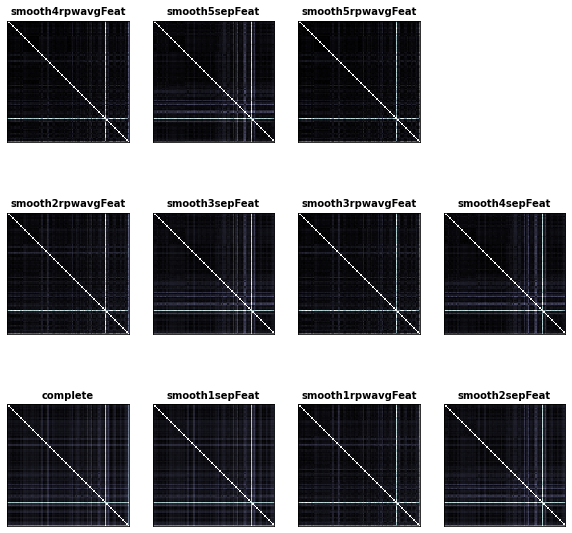

In [4]:
conv1_rdms = model_rdms.subset('brain_computational_model','conv1')
fig, ax, ret_val = rsatoolbox.vis.show_rdm(conv1_rdms, rdm_descriptor='measurement_model', figsize=(10,10))

These are the RDMs which were generated from convolutional layer 1 by different measurement models. Each RDM is labeled with the name of the measurement model. Also in the lower right corner the average RDM is plotted.

### Print information about a set of RDMs
The rsatoolbox objects can simply be passed to the print function to obtain a short description of their content.

In [5]:
conv1_rdms = model_rdms.subset('brain_computational_model','conv1')
print(conv1_rdms)

rsatoolbox.rdm.RDMs
11 RDM(s) over 92 conditions

dissimilarity_measure = 
Euclidean

dissimilarities[0] = 
[[0.00000000e+00 7.35978432e+08 5.35502528e+08 ... 1.34278669e+09
  1.34848320e+09 4.47360614e+09]
 [7.35978432e+08 0.00000000e+00 6.72164736e+08 ... 1.52816154e+09
  1.59405773e+09 4.56825293e+09]
 [5.35502528e+08 6.72164736e+08 0.00000000e+00 ... 1.40547021e+09
  1.39483494e+09 4.35671757e+09]
 ...
 [1.34278669e+09 1.52816154e+09 1.40547021e+09 ... 0.00000000e+00
  1.85234202e+09 4.90678682e+09]
 [1.34848320e+09 1.59405773e+09 1.39483494e+09 ... 1.85234202e+09
  0.00000000e+00 5.00813875e+09]
 [4.47360614e+09 4.56825293e+09 4.35671757e+09 ... 4.90678682e+09
  5.00813875e+09 0.00000000e+00]]

descriptors: 

rdm_descriptors: 
brain_computational_model = ['conv1', 'conv1', 'conv1', 'conv1', 'conv1', 'conv1', 'conv1', 'conv1', 'conv1', 'conv1', 'conv1']
measurement_model = ['complete', 'smooth1sepFeat', 'smooth1rpwavgFeat', 'smooth2sepFeat', 'smooth2rpwavgFeat', 'smooth3sepFeat', '

### Questions

Of course, you can also show all RDMs or select any other subset. Have a look at the different RDMs!

How many RDMs are there for each layer?

Generate a plot which shows all RDMs with the 'complete' measurement model.

How different do the different measurement models look to you and how different do the different layers look?


rsatoolbox.rdm.RDMs
9 RDM(s) over 92 conditions

dissimilarity_measure = 
Euclidean

dissimilarities[0] = 
[[0.00000000e+00 7.35978432e+08 5.35502528e+08 ... 1.34278669e+09
  1.34848320e+09 4.47360614e+09]
 [7.35978432e+08 0.00000000e+00 6.72164736e+08 ... 1.52816154e+09
  1.59405773e+09 4.56825293e+09]
 [5.35502528e+08 6.72164736e+08 0.00000000e+00 ... 1.40547021e+09
  1.39483494e+09 4.35671757e+09]
 ...
 [1.34278669e+09 1.52816154e+09 1.40547021e+09 ... 0.00000000e+00
  1.85234202e+09 4.90678682e+09]
 [1.34848320e+09 1.59405773e+09 1.39483494e+09 ... 1.85234202e+09
  0.00000000e+00 5.00813875e+09]
 [4.47360614e+09 4.56825293e+09 4.35671757e+09 ... 4.90678682e+09
  5.00813875e+09 0.00000000e+00]]

descriptors: 

rdm_descriptors: 
brain_computational_model = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7', 'fc8', 'prob']
measurement_model = ['complete', 'complete', 'complete', 'complete', 'complete', 'complete', 'complete', 'complete', 'complete']
index = [0, 11, 22, 33, 44,

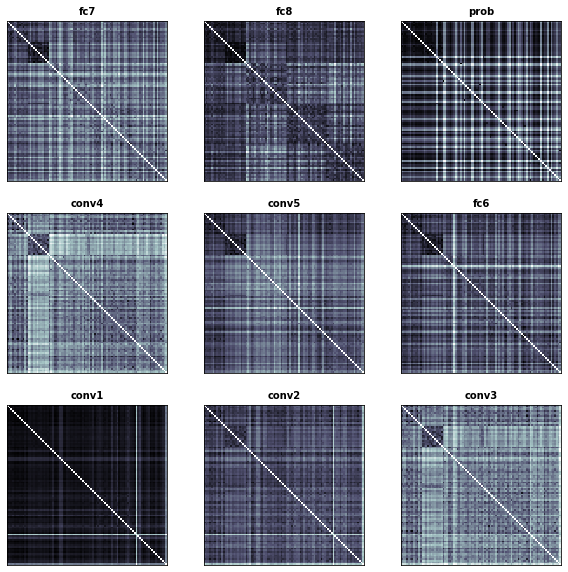

In [6]:
complete_rdms = model_rdms.subset('measurement_model','complete')
print(complete_rdms)
fig, ax, ret_val = rsatoolbox.vis.show_rdm(complete_rdms, rdm_descriptor='brain_computational_model', figsize=(10,10))

## Exercise 2: Fixed model inference
### Load data RDMs
Here we use simulated data to demonstrate RSA inference.
Since we know the true data-generating model in each case, we can tell when inference fails or succeeds.

For each data RDM, we obtain the name of the underlying Layer, a full width at half maximum (FWHM) value and a noise standard deviation. The FWHM value specifies the spatial range the simulated voxels average over. The noise standard deviation specifies how much noise was added to the voxel responses.

In [7]:
matlab_data = io.matlab.loadmat('rsatoolbox_demos/rdms_inferring/noisyModelRDMs_A2020.mat')
repr_names_matlab = matlab_data['reprNames']
fwhms_matlab = matlab_data['FWHMs']
noise_std_matlab = matlab_data['relNoiseStds']
rdms_matlab = matlab_data['noisyModelRDMs']
repr_names = [repr_names_matlab[i][0][0] for i in range(repr_names_matlab.shape[0])]
fwhms = fwhms_matlab.squeeze().astype('float')
noise_std = noise_std_matlab.squeeze().astype('float')
rdms_matrix = rdms_matlab.squeeze().astype('float')
rdms_matrix.shape

(4186, 9, 5, 4, 12)

Each RDM has 4186 entries.
There are 9 underlying representations (layers of CNN).
For each of these, there are 5 levels of smoothing, and 4 levels of added noise.
For each combination, measurements are sampled 12 times.

### Choose the data RDMs for inference

Here we choose which data RDMs we use for the exercise. You can change the representation, the noise level and the amount of averaging by changing the index values at the beginning.

We then convert the chosen data RDMs into an rsatoolbox RDMs object and display them as we did for the model RDMs.

The chosen ground truth model is:
conv3
with noise level:
3.0
with averaging width (full width at half magnitude):
0.0
rsatoolbox.rdm.RDMs
12 RDM(s) over 92 conditions

dissimilarity_measure = 
None

dissimilarities[0] = 
[[  0.         285.55175781 293.54159546 ... 295.60964966 312.26260376
  303.36230469]
 [285.55175781   0.         289.87716675 ... 288.91345215 300.00872803
  284.74438477]
 [293.54159546 289.87716675   0.         ... 289.0909729  308.39849854
  306.98782349]
 ...
 [295.60964966 288.91345215 289.0909729  ...   0.         298.66671753
  291.25585938]
 [312.26260376 300.00872803 308.39849854 ... 298.66671753   0.
  301.21057129]
 [303.36230469 284.74438477 306.98782349 ... 291.25585938 301.21057129
    0.        ]]

descriptors: 

rdm_descriptors: 
index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

pattern_descriptors: 
index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,

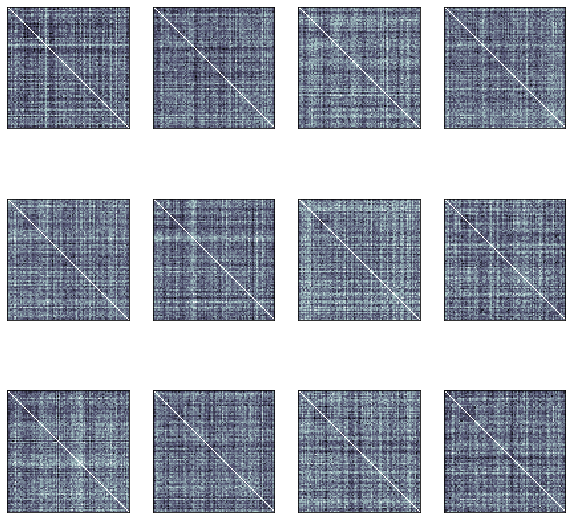

In [8]:
# indices choosing brain-computational model, noise level, and the size of the kernel with which each voxel samples the neural activity
i_rep   = 2 #np.random.randint(len(repr_names)) 
i_noise = 1 #np.random.randint(len(noise_std))
i_fwhm  = 0 #np.random.randint(len(fwhms))

# print the chosen representation definition
repr_name = repr_names[i_rep]
print('The chosen ground truth model is:')
print(repr_name)
print('with noise level:')
print(noise_std[i_noise])
print('with averaging width (full width at half magnitude):')
print(fwhms[i_fwhm])

# put the rdms into an RDMs object and show it
rdms_data = rsatoolbox.rdm.RDMs(rdms_matrix[:, i_rep, i_fwhm, i_noise, :].transpose())

fig, ax, ret_val = rsatoolbox.vis.show_rdm(rdms_data, figsize=(10,10))
print(rdms_data)

### Define fixed models
An "RDM model" is an rsatoolbox object that can predict a data RDM.
For example, a flexible RDM model may contain a set of predictor RDMs, which predict the data RDM as a weighted combination.
Here we use fixed RDM models, which contain just a single RDM with no parameters to be fitted.

Models are generated by first choosing the RDM, in this case the one with the right "brain_computational_model" and the "measurement_model" "complete", which corresponds to no distortions added. This object is then passed to the function `rsatoolbox.model.ModelFixed`, which generates a fixed RDM model. These RDM models are then collected in the list `models`. 

In [9]:
models = []
for i_model in np.unique(model_names):
    rdm_m = model_rdms.subset('brain_computational_model', i_model).subset('measurement_model','complete')
    m = rsatoolbox.model.ModelFixed(i_model, rdm_m)
    models.append(m)

print('created the following models:')
for i in range(len(models)):
    print(models[i].name)

created the following models:
conv1
conv2
conv3
conv4
conv5
fc6
fc7
fc8
prob


### Compare model RDMs to measured RDMs
Evaluate models naively, i.e. simply compute the average correlation to the data RDMs.

In [10]:
print(rdms_data)

rsatoolbox.rdm.RDMs
12 RDM(s) over 92 conditions

dissimilarity_measure = 
None

dissimilarities[0] = 
[[  0.         285.55175781 293.54159546 ... 295.60964966 312.26260376
  303.36230469]
 [285.55175781   0.         289.87716675 ... 288.91345215 300.00872803
  284.74438477]
 [293.54159546 289.87716675   0.         ... 289.0909729  308.39849854
  306.98782349]
 ...
 [295.60964966 288.91345215 289.0909729  ...   0.         298.66671753
  291.25585938]
 [312.26260376 300.00872803 308.39849854 ... 298.66671753   0.
  301.21057129]
 [303.36230469 284.74438477 306.98782349 ... 291.25585938 301.21057129
    0.        ]]

descriptors: 

rdm_descriptors: 
index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

pattern_descriptors: 
index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68

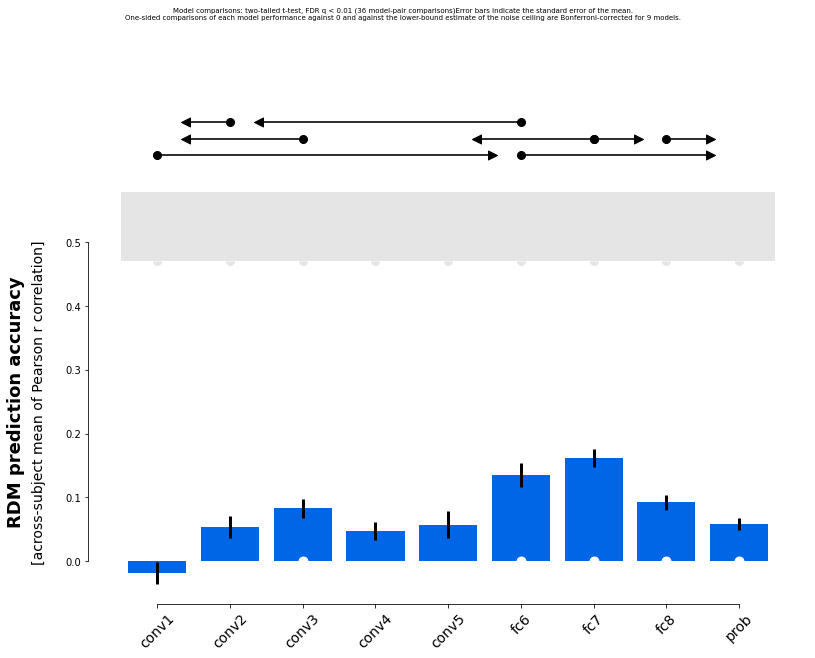

In [11]:
results_1 = rsatoolbox.inference.eval_fixed(models, rdms_data, method='corr')
rsatoolbox.vis.plot_model_comparison(results_1);

In these plots the errorbars are based on the variability across subjects, which can be handled analytically. The lines above the plot show which pairwise comparisons are significant. The upper bound of the noise ceiling is computed by finding the RDM with the highest possible average similarity to the measured RDMs. This is not 1 because the RDMs for different subjects or measurements differ. The lower bound of the noise ceiling is a leave one out crossvalidation of this averaging procedure, i.e. we find the RDM to perform optimally on all but one of the RDMs and evaluate this average RDM on the left-out RDM. Each RDM is left out once and the correlations are averaged.

To take the many pairwise model comparisons into account in performing inference, we can choose a correction for multiple comparisons: We can either control the family wise error rate (FWER) or the false discovery rate (FDR). Here we use a Bonferroni correction for FWER and the Benjamini-Hochberg procedure for FDR.

The basic information from a results object can also be printed with the simple print command:

In [12]:
print(results_1)

Results for running fixed evaluation for corr on 9 models:

Model |   Eval ± SEM   | p (against 0) | p (against NC) |
---------------------------------------------------------
conv1 | -0.018 ± 0.018 |        0.836  |       < 0.001  |
conv2 |  0.053 ± 0.017 |        0.005  |       < 0.001  |
conv3 |  0.083 ± 0.014 |      < 0.001  |       < 0.001  |
conv4 |  0.047 ± 0.014 |        0.004  |       < 0.001  |
conv5 |  0.057 ± 0.021 |        0.010  |       < 0.001  |
fc6   |  0.136 ± 0.019 |      < 0.001  |       < 0.001  |
fc7   |  0.162 ± 0.014 |      < 0.001  |       < 0.001  |
fc8   |  0.092 ± 0.012 |      < 0.001  |       < 0.001  |
prob  |  0.058 ± 0.009 |      < 0.001  |       < 0.001  |

p-values are based on uncorrected t-tests


Furthermore, the results object has a few functions called `get_*` to access results like the mean values, errorbars, the noise ceiling etc., and `test_*` functions that return the p-values of the various tests.

### Bootstrapping
To estimate our uncertainty about the models' performance once we want to include the uncertainty due to random stimulus selection, we can perform bootstrapping. 

#### Model comparison by bootstrapping the subjects
We can bootstrap resample the subjects, which estimates how variable the model performances would be if we repeted the experiment with the same stimuli but new subjects from the same population. Based on that uncertainty estimate, we can statistically compare model performances.

In the limit of many bootstrap samples this estimate converges exactly to the variance we get from the much faster analytical solution used by eval_fixed. Thus, this analysis is usually not used in practice. It is the simplest version of bootstrapping though and thus, a good starting point to illustrate the use of the bootstrap. The following should thus results in very similar results as `results_1`. 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.84it/s]


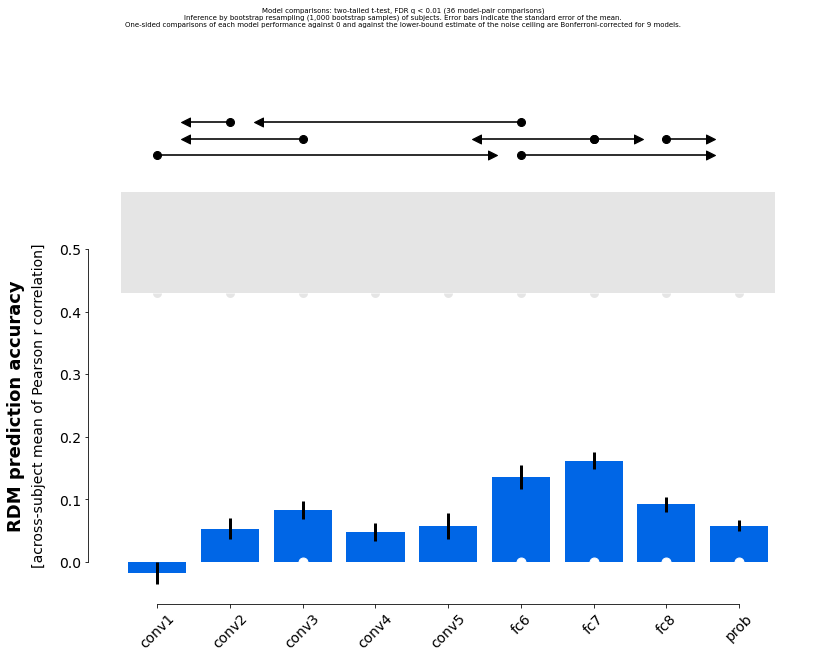

In [13]:
results_2a = rsatoolbox.inference.eval_bootstrap_rdm(models, rdms_data, method='corr')
rsatoolbox.vis.plot_model_comparison(results_2a);

In [14]:
print(results_2a)

Results for running bootstrap_rdm evaluation for corr on 9 models:

Model |   Eval ± SEM   | p (against 0) | p (against NC) |
---------------------------------------------------------
conv1 | -0.018 ± 0.018 |        0.838  |       < 0.001  |
conv2 |  0.053 ± 0.017 |        0.005  |       < 0.001  |
conv3 |  0.083 ± 0.015 |      < 0.001  |       < 0.001  |
conv4 |  0.048 ± 0.014 |        0.004  |       < 0.001  |
conv5 |  0.057 ± 0.020 |        0.008  |       < 0.001  |
fc6   |  0.136 ± 0.019 |      < 0.001  |       < 0.001  |
fc7   |  0.162 ± 0.014 |      < 0.001  |       < 0.001  |
fc8   |  0.093 ± 0.012 |      < 0.001  |       < 0.001  |
prob  |  0.058 ± 0.009 |      < 0.001  |       < 0.001  |

p-values are based on uncorrected t-tests


#### Model comparison by bootstrapping the stimuli
We can alternatively bootstrap resample the stimuli to estimate how much model performance would vary if we repeated the experiment with the same subjects using a new sample of stimuli from the same population. This analysis is not analytically solvable.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.87it/s]


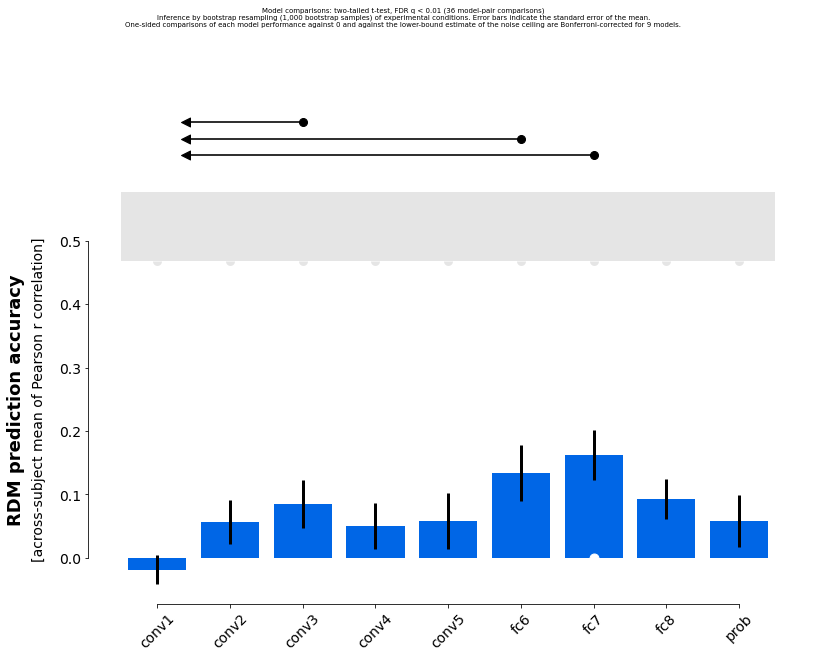

In [15]:
results_2b = rsatoolbox.inference.eval_bootstrap_pattern(models, rdms_data, method='corr')
rsatoolbox.vis.plot_model_comparison(results_2b);

#### Model comparison by bootstrapping both stimuli and subjects
Finally, we can bootstrap resample both stimuli and subjects to estimate how variable the model performances would be if we repeated the experiment with new subjects and new stimuli from their respective populations:

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 67.44it/s]


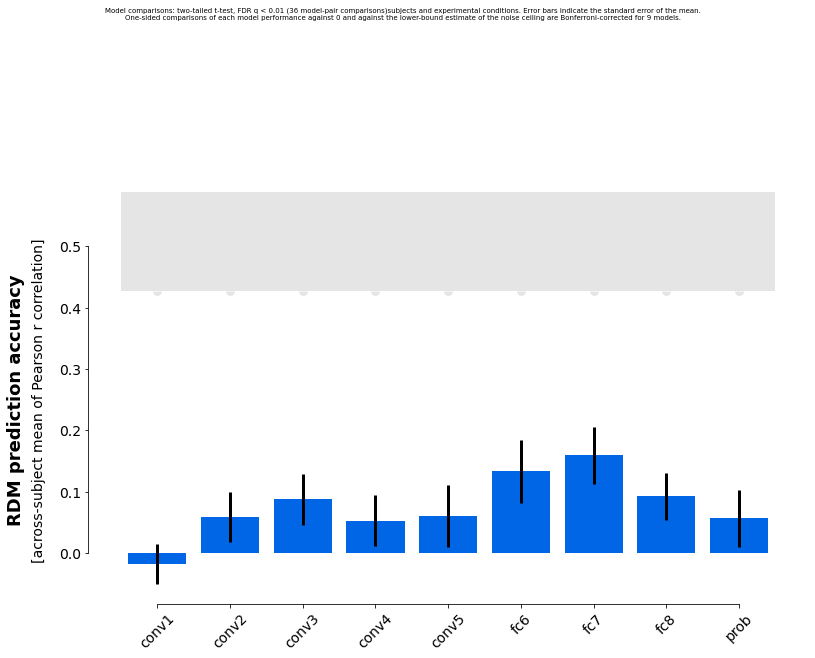

In [16]:
results_2c = rsatoolbox.inference.eval_bootstrap(models, rdms_data, method='corr')
rsatoolbox.vis.plot_model_comparison(results_2c);

As we note in the paper "Statistical inference on representational geometries", this estimate is overly conservative though. It yields too large errorbars. To aleviate this, we there suggest a correction, based on combining the errorbars from bootstrapping both stimuli and subjects with the separate bootstraps for the two factors. This is implemented in the `eval_dual_bootstrap` method:

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.48it/s]


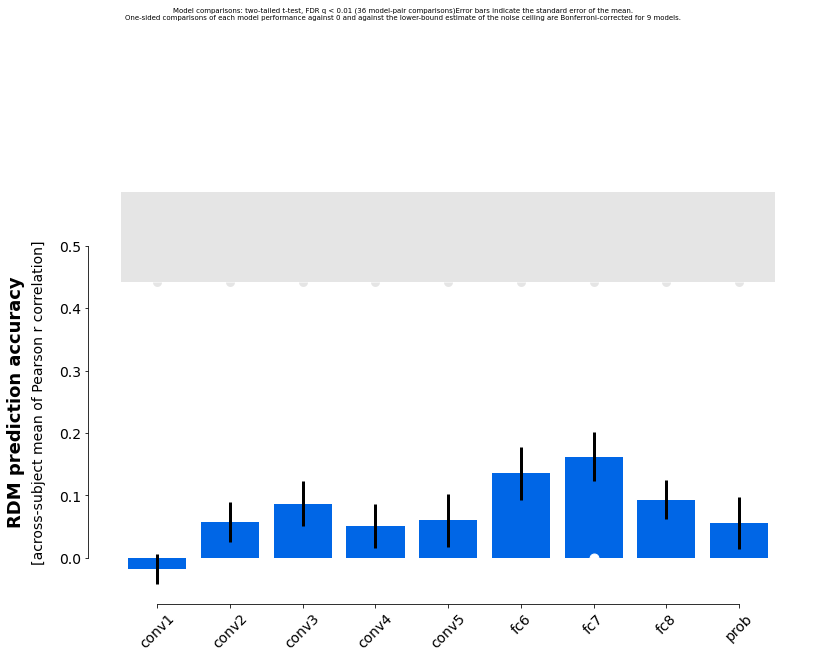

In [17]:
results_2d = rsatoolbox.inference.eval_dual_bootstrap(models, rdms_data, method='corr')
rsatoolbox.vis.plot_model_comparison(results_2d);

Indeed, the SEMs for the model evaluations are also smaller here:

In [18]:
print(results_2c)

Results for running bootstrap evaluation for corr on 9 models:

Model |   Eval ± SEM   | p (against 0) | p (against NC) |
---------------------------------------------------------
conv1 | -0.019 ± 0.033 |        0.709  |       < 0.001  |
conv2 |  0.058 ± 0.041 |        0.091  |       < 0.001  |
conv3 |  0.087 ± 0.042 |        0.031  |       < 0.001  |
conv4 |  0.053 ± 0.041 |        0.115  |       < 0.001  |
conv5 |  0.060 ± 0.051 |        0.133  |       < 0.001  |
fc6   |  0.133 ± 0.051 |        0.012  |       < 0.001  |
fc7   |  0.159 ± 0.046 |        0.003  |       < 0.001  |
fc8   |  0.092 ± 0.038 |        0.017  |       < 0.001  |
prob  |  0.056 ± 0.047 |        0.128  |       < 0.001  |

p-values are based on uncorrected t-tests


In [19]:
print(results_2d)

Results for running dual_bootstrap evaluation for corr on 9 models:

Model |   Eval ± SEM   | p (against 0) | p (against NC) |
---------------------------------------------------------
conv1 | -0.018 ± 0.025 |        0.762  |       < 0.001  |
conv2 |  0.057 ± 0.032 |        0.053  |       < 0.001  |
conv3 |  0.087 ± 0.035 |        0.016  |       < 0.001  |
conv4 |  0.051 ± 0.035 |        0.087  |       < 0.001  |
conv5 |  0.060 ± 0.043 |        0.096  |       < 0.001  |
fc6   |  0.135 ± 0.042 |        0.004  |       < 0.001  |
fc7   |  0.162 ± 0.039 |      < 0.001  |       < 0.001  |
fc8   |  0.093 ± 0.031 |        0.006  |       < 0.001  |
prob  |  0.056 ± 0.041 |        0.101  |       < 0.001  |

p-values are based on uncorrected t-tests


### Questions
Does the right model win? And do the mean estimates from bootstrapping differ from the evaluations over the whole dataset?

Compare the results for the different bootstrapping methods. Which method leads to the widest confidence intervals, which one to the smallest?

((DJM: Notice that here the correct model (conv3, from which the data were generated) did *not* give the best fit to the data (the best fit was "fc7). This is because the data contains smoothing and noise, which are not present in the models tested. However, by using a different RDM comparison method, `corr_cov`, which adjusts for autocorrelations within the RDMs, the correct model *does* win:  

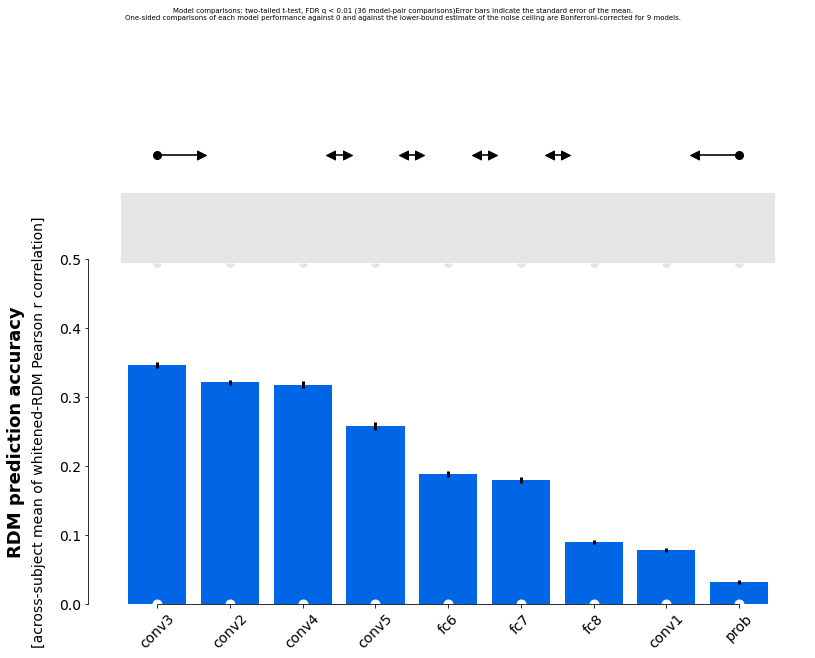

In [20]:
results_1b = rsatoolbox.inference.eval_fixed(models, rdms_data, method='corr_cov')
rsatoolbox.vis.plot_model_comparison(results_1b, test_pair_comparisons='arrows', sort='descend');

Here the bar chart is also sorted, which makes the arrow plot more concise and easier to interpret. Also notice that the prediction accuracies are now substantially higher, and the error bars are substantially smaller.))

## Exercise 3: Crossvalidation for flexible models
### Defining flexible models
Here we use a type of flexible model called a *selection model*. This type of model specifies that the true RDM is one from a list of RDMs. To evaluate flexible models, they have to be fitted to data, i.e. we need to provide some data, which can be used to adjust the RDM-prediction of the model. For a selection model, the fitting process simply selects the RDM that performs best on the training data. The model will perform better on this data than on independent data. An unbiased performance estimate therefore requires independent test data. Crossvalidation is a data-efficient way of obtaining an unbiased performance estimate.

We first have to generate the selection models. This process is the same as for fixed models, but uses `rsatoolbox.model.ModelSelect` and passes multiple RDMs instead of a single one:

In [21]:
models_flex = []
for i_model in np.unique(model_names):
    models_flex.append(rsatoolbox.model.ModelSelect(i_model,
        model_rdms.subset('brain_computational_model', i_model)))

print('created the following models:')
for i in range(len(models_flex)):
    print(models_flex[i].name)

created the following models:
conv1
conv2
conv3
conv4
conv5
fc6
fc7
fc8
prob


In [22]:
print('There are still ', len(models_flex), ' models...')
print('But now each models contains multiple candidate RDMs:')
for i in range(len(models_flex)):
    print((models_flex[i]).rdm.shape)

There are still  9  models...
But now each models contains multiple candidate RDMs:
(11, 4186)
(11, 4186)
(11, 4186)
(11, 4186)
(11, 4186)
(2, 4186)
(2, 4186)
(2, 4186)
(2, 4186)


### Crossvalidation
As a first step, we split our data into training and test sets, which should not share either subjects or stimuli. To do so, we split each dimension into k groups and leave one of these groups out as a testset and use all others as training data. Models choose their parameters to maximize performance on the training set and are evaluated on the test set. Additionally a so-called *ceil set* is created, which contains the data from the training subjects for the test stimuli, which is necessary for calculating a noise ceiling.

The variables `k_pattern` and `k_rdm` specify how many folds should be formed over stimuli and subjects, respectively.

In [23]:
train_set, test_set, ceil_set = rsatoolbox.inference.sets_k_fold(rdms_data, k_pattern=3, k_rdm=2)

With these sets we can now evaluate our models, as we did without crossvalidaton, and plot the results. The performance estimates will be averaged across folds and we obtain a single performance estimate without errorbars. The variability over cross-validation folds are not indicative of the variability across independent datasets. Although training and test data are independent of each other in each fold, performance estimates are not independent across folds of crossvalidation.

/home/dm01/.conda/envs/cognestic23/lib/python3.11/site-packages/rsatoolbox/vis/model_plot.py:232: UserWarning: tests deactivated as crossvalidation does notprovide uncertainty estimate
  warnings.warn('tests deactivated as crossvalidation does not'
/home/dm01/.conda/envs/cognestic23/lib/python3.11/site-packages/rsatoolbox/vis/model_plot.py:238: UserWarning: errorbars deactivated as crossvalidation does notprovide uncertainty estimate
  warnings.warn('errorbars deactivated as crossvalidation does not'


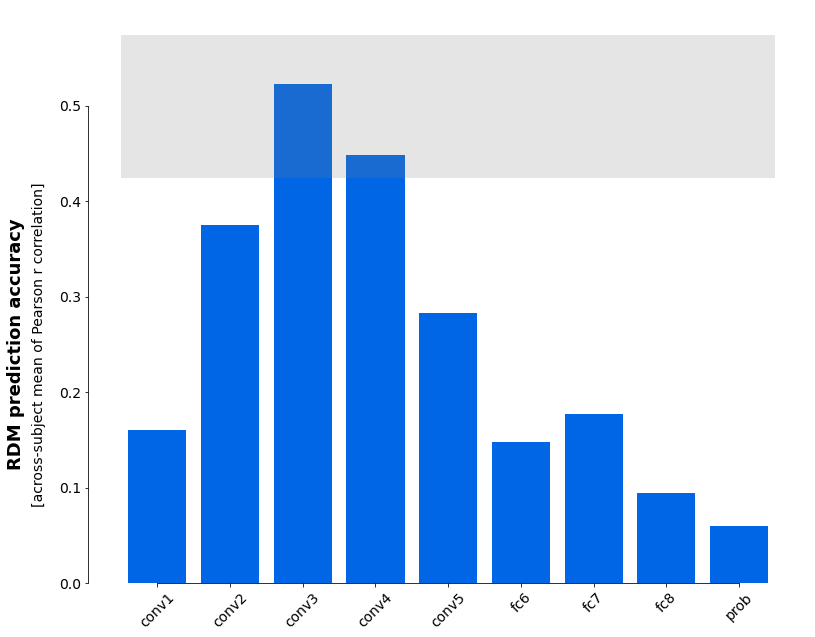

In [24]:
results_3_cv = rsatoolbox.inference.crossval(models_flex, rdms_data, train_set, test_set,
                                        ceil_set=ceil_set, method='corr')
# plot results
rsatoolbox.vis.plot_model_comparison(results_3_cv);

### Bootstrapped Crossvalidation

We can perform bootstrapping around the crossvalidation to get uncertainty estimates for the evaluation and for model comparison. This is implemented in the eval_dual_bootstrap method and can be activated by simply changing the k_pattern and k_rdm inputs. Here we compute only 100 bootstrap samples to keep the computation time short enough for demonstrations. For accurate inference, please run more samples of course!

This method internally applies the crossvalidation variance correction we introduce in the paper "Statistical inference on representational geometries".

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.61it/s]

Took  62.25137448310852  s


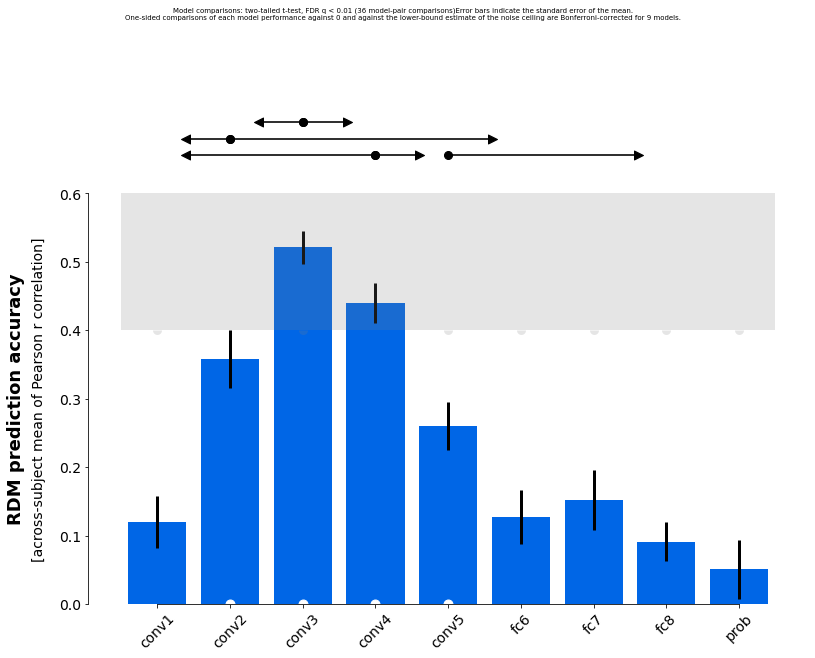

In [25]:
tic = time.time()
results_3_full = rsatoolbox.inference.eval_dual_bootstrap(models_flex, rdms_data, k_pattern=2, k_rdm=2, method='corr', N=100)
print('Took ', time.time()-tic,' s')
# plot results
rsatoolbox.vis.plot_model_comparison(results_3_full);

### Questions

Does the right model win?

Try some different settings for the crossvalidation: How do the results change when you make the training and test sets larger or smaller?
